# Train a model on the deep-snow dataset

In [1]:
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
from glob import glob
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import pickle

import deep_snow.models
import deep_snow.dataset

## Prepare dataloader

In [2]:
# get paths to data
train_data_dir = '/home/jovyan/shared-public/deep-snow/data/subsets_v2/train'
train_path_list = glob(f'{train_data_dir}/ASO_50M_SD*.nc')

val_data_dir = '/home/jovyan/shared-public/deep-snow/data/subsets_v2/val'
val_path_list = glob(f'{val_data_dir}/ASO_50M_SD*.nc')

In [3]:
# to test code with a small sample of the data
import random
n_imgs = 16

train_path_list = random.sample(train_path_list, n_imgs )
val_path_list = random.sample(val_path_list, n_imgs)

In [4]:
# define data to be returned by dataloader
selected_channels = [
    # ASO products
    'aso_sd', # ASO lidar snow depth (target dataset)
    'aso_gap_map', # gaps in ASO data
    
    # Sentinel-1 products
    'snowon_vv', # snow on Sentinel-1 VV polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowon_vh', # snow on Sentinel-1 VH polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowoff_vv', # snow off Sentinel-1 VV polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowoff_vh', # snow off Sentinel-1 VH polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowon_vv_mean', # snow on Sentinel-1 VV polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowon_vh_mean', # snow on Sentinel-1 VH polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowoff_vv_mean', # snow off Sentinel-1 VV polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowoff_vh_mean', # snow off Sentinel-1 VH polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowon_cr', # cross ratio, snowon_vh - snowon_vv
    'snowoff_cr', # cross ratio, snowoff_vh - snowoff_vv
    'delta_cr', # change in cross ratio, snowon_cr - snowoff_cr
    'rtc_gap_map', # gaps in Sentinel-1 data
    'rtc_mean_gap_map', # gaps in Sentinel-1 mean data
    
    # Sentinel-2 products 
    'aerosol_optical_thickness', # snow on Sentinel-2 aerosol optical thickness band 
    'coastal_aerosol', # snow on Sentinel-2 coastal aerosol band
    'blue', # snow on Sentinel-2 blue band
    'green', # snow on Sentinel-2 green band
    'red', # snow on Sentinel-2 red band
    'red_edge1', # snow on Sentinel-2 red edge 1 band
    'red_edge2', # snow on Sentinel-2 red edge 2 band
    'red_edge3', # snow on Sentinel-2 red edge 3 band
    'nir', # snow on Sentinel-2 near infrared band
    'water_vapor', # snow on Sentinel-2 water vapor
    'swir1', # snow on Sentinel-2 shortwave infrared band 1
    'swir2', # snow on Sentinel-2 shortwave infrared band 2
    'scene_class_map', # snow on Sentinel-2 scene classification product
    'water_vapor_product', # snow on Sentinel-2 water vapor product
    'ndvi', # Normalized Difference Vegetation Index from Sentinel-2
    'ndsi', # Normalized Difference Snow Index from Sentinel-2
    'ndwi', # Normalized Difference Water Index from Sentinel-2
    's2_gap_map', # gaps in Sentinel-2 data

    # PROBA-V global land cover dataset (Buchhorn et al., 2020)
    'fcf', # fractional forest cover
    
    # COP30 digital elevation model      
    'elevation',

    # latitude and longitude
    'latitude',
    'longitude',

    # day of water year
    'dowy'
                    ]

# prepare training and validation dataloaders
train_data = deep_snow.dataset.Dataset(train_path_list, selected_channels, norm=True)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_data = deep_snow.dataset.Dataset(val_path_list, selected_channels, norm=True)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=1, shuffle=True)

In [5]:
# define input channels for model
input_channels = [
    'snowon_vv',
    'snowon_vh',
    'snowoff_vv',
    'snowoff_vh',
    'blue',
    'green',
    'red',
    'fcf',
    'elevation',
    'ndvi',
    'ndsi',
    'ndwi',
    'snowon_cr',
    'snowoff_cr']

## Train model

In [6]:
# import model
# model = deep_snow.models.SimpleCNN(n_input_channels=len(input_channels))
# model = deep_snow.models.UNet(n_input_channels=len(input_channels))
# model = deep_snow.models.ResUNet(n_input_channels=len(input_channels))
# model = deep_snow.models.ResDepth(n_input_channels=len(input_channels))
# model = deep_snow.models.VisionTransformer(n_input_channels=len(input_channels))

model = deep_snow.models.SimpleCNN(n_input_channels=len(input_channels))
model.to('cuda');  # Run on GPU

# name your model
model_name = 'janedoe_SimpleCNN_v0'

In [7]:
# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=0.0003)
loss_fn = nn.MSELoss()
epochs = 50

train_loss = []
val_loss = []

# training and validation loop
for epoch in range(epochs):
    print(f'\nStarting epoch {epoch+1}')
    epoch_loss = []
    val_temp_loss = []

    # Loop through training data with tqdm progress bar
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch", ncols=130)
    for data_tuple in pbar:
        model.train()
        optimizer.zero_grad()

        # read data into dictionary
        data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}
        # prepare inputs by concatenating along channel dimension
        inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')

        # generate prediction
        pred_sd = model(inputs)

        # Limit prediction to areas with valid data
        pred_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, pred_sd, torch.zeros_like(pred_sd).to('cuda'))
        aso_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda')== 0, data_dict['aso_sd'].to('cuda'), torch.zeros_like(pred_sd).to('cuda'))

        # Calculate loss
        loss = loss_fn(pred_sd, aso_sd.to('cuda'))
        epoch_loss.append(loss.item())

        # Update tqdm progress bar with batch loss
        pbar.set_postfix({'batch loss': loss.item(), 'mean epoch loss': np.mean(epoch_loss)})


        loss.backward()  # Propagate the gradients in backward pass
        optimizer.step()

    train_loss.append(np.mean(epoch_loss))
    print(f'Training loss: {np.mean(epoch_loss)}')

    # Run model on validation data with tqdm progress bar
    for data_tuple in tqdm(val_loader, desc="Validation", unit="batch"):
        with torch.no_grad():
            model.eval()
            
            # read data into dictionary
            data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}
            # prepare inputs by concatenating along channel dimension
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
    
            # generate prediction
            pred_sd = model(inputs)
    
            # Limit prediction to areas with valid data
            pred_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, pred_sd, torch.zeros_like(pred_sd).to('cuda'))
            aso_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, data_dict['aso_sd'].to('cuda'), torch.zeros_like(pred_sd).to('cuda'))
    
            # Calculate loss
            loss = loss_fn(pred_sd, aso_sd.to('cuda'))
            val_temp_loss.append(loss.item())

    val_loss.append(np.mean(val_temp_loss))
    print(f'Validation loss: {np.mean(val_temp_loss)}')
    
    # # save model
    # torch.save(model.state_dict(), f'../../../weights/{model_name}')

    # # save loss 
    # with open(f'../../../loss/{model_name}_val_loss.pkl', 'wb') as f:
    #     pickle.dump(val_loss, f)
        
    # with open(f'../../../loss/{model_name}_train_loss.pkl', 'wb') as f:
    #     pickle.dump(train_loss, f)


Starting epoch 1


Epoch 1/50: 100%|█████████████████████████████████████| 1/1 [00:05<00:00,  5.52s/batch, batch loss=0.0068, mean epoch loss=0.0068]


Training loss: 0.006797956768423319


Validation: 100%|██████████| 16/16 [00:02<00:00,  5.70batch/s]


Validation loss: 0.004905560562171729

Starting epoch 2


Epoch 2/50: 100%|███████████████████████████████████| 1/1 [00:01<00:00,  1.09s/batch, batch loss=0.00545, mean epoch loss=0.00545]


Training loss: 0.005450532305985689


Validation: 100%|██████████| 16/16 [00:01<00:00, 13.62batch/s]


Validation loss: 0.0038725798172762893

Starting epoch 3


Epoch 3/50: 100%|███████████████████████████████████| 1/1 [00:01<00:00,  1.03s/batch, batch loss=0.00438, mean epoch loss=0.00438]


Training loss: 0.004380518104881048


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.18batch/s]


Validation loss: 0.002939860669030736

Starting epoch 4


Epoch 4/50: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.02batch/s, batch loss=0.00347, mean epoch loss=0.00347]


Training loss: 0.003466167487204075


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.95batch/s]


Validation loss: 0.002117058499178981

Starting epoch 5


Epoch 5/50: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.02batch/s, batch loss=0.00274, mean epoch loss=0.00274]


Training loss: 0.0027380569372326136


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.09batch/s]


Validation loss: 0.001479164307902181

Starting epoch 6


Epoch 6/50: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.04batch/s, batch loss=0.00233, mean epoch loss=0.00233]


Training loss: 0.002327907830476761


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.15batch/s]


Validation loss: 0.001300045618517487

Starting epoch 7


Epoch 7/50: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.04batch/s, batch loss=0.00254, mean epoch loss=0.00254]


Training loss: 0.0025412626564502716


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.91batch/s]


Validation loss: 0.0014480153835521037

Starting epoch 8


Epoch 8/50: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.03batch/s, batch loss=0.00294, mean epoch loss=0.00294]


Training loss: 0.0029374388977885246


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.15batch/s]


Validation loss: 0.0013967036958888457

Starting epoch 9


Epoch 9/50: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.06batch/s, batch loss=0.00282, mean epoch loss=0.00282]


Training loss: 0.0028242904227226973


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.23batch/s]


Validation loss: 0.0012780537968168915

Starting epoch 10


Epoch 10/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.03batch/s, batch loss=0.00251, mean epoch loss=0.00251]


Training loss: 0.0025089136324822903


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.66batch/s]


Validation loss: 0.0012624046980462822

Starting epoch 11


Epoch 11/50: 100%|████████████████████████████████████| 1/1 [00:00<00:00,  1.08batch/s, batch loss=0.0023, mean epoch loss=0.0023]


Training loss: 0.0022963520605117083


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.69batch/s]


Validation loss: 0.001354295668171801

Starting epoch 12


Epoch 12/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.01batch/s, batch loss=0.00224, mean epoch loss=0.00224]


Training loss: 0.0022412880789488554


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.83batch/s]


Validation loss: 0.0014806022759810133

Starting epoch 13


Epoch 13/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.02batch/s, batch loss=0.00227, mean epoch loss=0.00227]


Training loss: 0.00227404129691422


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.70batch/s]


Validation loss: 0.0015776176653741203

Starting epoch 14


Epoch 14/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.05batch/s, batch loss=0.00232, mean epoch loss=0.00232]


Training loss: 0.0023183668963611126


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.44batch/s]


Validation loss: 0.001612994991667449

Starting epoch 15


Epoch 15/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.04batch/s, batch loss=0.00233, mean epoch loss=0.00233]


Training loss: 0.002331961877644062


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.15batch/s]


Validation loss: 0.0015805389144540882

Starting epoch 16


Epoch 16/50: 100%|████████████████████████████████████| 1/1 [00:00<00:00,  1.04batch/s, batch loss=0.0023, mean epoch loss=0.0023]


Training loss: 0.0022995583713054657


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.33batch/s]


Validation loss: 0.0014873482045878461

Starting epoch 17


Epoch 17/50: 100%|██████████████████████████████████| 1/1 [00:01<00:00,  1.02s/batch, batch loss=0.00222, mean epoch loss=0.00222]


Training loss: 0.002224611584097147


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.40batch/s]


Validation loss: 0.001353644461559611

Starting epoch 18


Epoch 18/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.01batch/s, batch loss=0.00213, mean epoch loss=0.00213]


Training loss: 0.0021265666000545025


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.91batch/s]


Validation loss: 0.001212408072021276

Starting epoch 19


Epoch 19/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.01batch/s, batch loss=0.00204, mean epoch loss=0.00204]


Training loss: 0.0020383414812386036


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.68batch/s]


Validation loss: 0.0011087397708919866

Starting epoch 20


Epoch 20/50: 100%|██████████████████████████████████████| 1/1 [00:00<00:00,  1.00batch/s, batch loss=0.002, mean epoch loss=0.002]


Training loss: 0.0019987239502370358


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.50batch/s]


Validation loss: 0.001075859700698345

Starting epoch 21


Epoch 21/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.00batch/s, batch loss=0.00202, mean epoch loss=0.00202]


Training loss: 0.002017848426476121


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.68batch/s]


Validation loss: 0.0010751587097637127

Starting epoch 22


Epoch 22/50: 100%|██████████████████████████████████| 1/1 [00:01<00:00,  1.03s/batch, batch loss=0.00202, mean epoch loss=0.00202]


Training loss: 0.0020235078409314156


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.76batch/s]


Validation loss: 0.0010494872626125584

Starting epoch 23


Epoch 23/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.00batch/s, batch loss=0.00195, mean epoch loss=0.00195]


Training loss: 0.0019520130008459091


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.82batch/s]


Validation loss: 0.0010183477500973481

Starting epoch 24


Epoch 24/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.03batch/s, batch loss=0.00185, mean epoch loss=0.00185]


Training loss: 0.001849417807534337


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.19batch/s]


Validation loss: 0.0010172910778134536

Starting epoch 25


Epoch 25/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.03batch/s, batch loss=0.00178, mean epoch loss=0.00178]


Training loss: 0.0017801474314182997


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.88batch/s]


Validation loss: 0.0010374323079158643

Starting epoch 26


Epoch 26/50: 100%|██████████████████████████████████| 1/1 [00:01<00:00,  1.07s/batch, batch loss=0.00175, mean epoch loss=0.00175]


Training loss: 0.0017493295017629862


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.32batch/s]


Validation loss: 0.001039392589593291

Starting epoch 27


Epoch 27/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.02batch/s, batch loss=0.00172, mean epoch loss=0.00172]


Training loss: 0.0017174388049170375


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.69batch/s]


Validation loss: 0.0009990212947119659

Starting epoch 28


Epoch 28/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.02batch/s, batch loss=0.00165, mean epoch loss=0.00165]


Training loss: 0.001653383020311594


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.73batch/s]


Validation loss: 0.0009447529569079904

Starting epoch 29


Epoch 29/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.02batch/s, batch loss=0.00158, mean epoch loss=0.00158]


Training loss: 0.0015790543984621763


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.98batch/s]


Validation loss: 0.0009426482055197027

Starting epoch 30


Epoch 30/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.00batch/s, batch loss=0.00155, mean epoch loss=0.00155]


Training loss: 0.001552932895720005


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.99batch/s]


Validation loss: 0.0009655750181671863

Starting epoch 31


Epoch 31/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.03batch/s, batch loss=0.00154, mean epoch loss=0.00154]


Training loss: 0.0015385255683213472


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.29batch/s]


Validation loss: 0.0009357905018338997

Starting epoch 32


Epoch 32/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.04batch/s, batch loss=0.00147, mean epoch loss=0.00147]


Training loss: 0.0014696407597512007


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.73batch/s]


Validation loss: 0.0009210139810407192

Starting epoch 33


Epoch 33/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.02batch/s, batch loss=0.00142, mean epoch loss=0.00142]


Training loss: 0.0014224621700122952


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.56batch/s]


Validation loss: 0.0009371824291410924

Starting epoch 34


Epoch 34/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.01batch/s, batch loss=0.00141, mean epoch loss=0.00141]


Training loss: 0.001406829571351409


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.68batch/s]


Validation loss: 0.0009312408541934936

Starting epoch 35


Epoch 35/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.01batch/s, batch loss=0.00136, mean epoch loss=0.00136]


Training loss: 0.0013599162921309471


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.73batch/s]


Validation loss: 0.0009294189232407213

Starting epoch 36


Epoch 36/50: 100%|████████████████████████████████████| 1/1 [00:00<00:00,  1.01batch/s, batch loss=0.0013, mean epoch loss=0.0013]


Training loss: 0.0013017426244914532


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.59batch/s]


Validation loss: 0.0009749336781497142

Starting epoch 37


Epoch 37/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.01batch/s, batch loss=0.00129, mean epoch loss=0.00129]


Training loss: 0.0012859380804002285


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.43batch/s]


Validation loss: 0.0009534196385529992

Starting epoch 38


Epoch 38/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.02batch/s, batch loss=0.00123, mean epoch loss=0.00123]


Training loss: 0.0012333366321399808


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.95batch/s]


Validation loss: 0.0009211482559945416

Starting epoch 39


Epoch 39/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.03batch/s, batch loss=0.00119, mean epoch loss=0.00119]


Training loss: 0.001187011948786676


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.18batch/s]


Validation loss: 0.0009296654207153754

Starting epoch 40


Epoch 40/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.03batch/s, batch loss=0.00117, mean epoch loss=0.00117]


Training loss: 0.0011661319294944406


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.06batch/s]


Validation loss: 0.0009243076917688775

Starting epoch 41


Epoch 41/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.04batch/s, batch loss=0.00111, mean epoch loss=0.00111]


Training loss: 0.0011101108975708485


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.23batch/s]


Validation loss: 0.0009710288695341518

Starting epoch 42


Epoch 42/50: 100%|████████████████████████████████████| 1/1 [00:00<00:00,  1.04batch/s, batch loss=0.0011, mean epoch loss=0.0011]


Training loss: 0.0010981438681483269


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.43batch/s]


Validation loss: 0.0009486879547790927

Starting epoch 43


Epoch 43/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.04batch/s, batch loss=0.00105, mean epoch loss=0.00105]


Training loss: 0.0010526925325393677


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.16batch/s]


Validation loss: 0.0009564695296162551

Starting epoch 44


Epoch 44/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.04batch/s, batch loss=0.00104, mean epoch loss=0.00104]


Training loss: 0.001044146134518087


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.09batch/s]


Validation loss: 0.0009714161488536543

Starting epoch 45


Epoch 45/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.05batch/s, batch loss=0.00101, mean epoch loss=0.00101]


Training loss: 0.0010127515997737646


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.31batch/s]


Validation loss: 0.0010416923512992504

Starting epoch 46


Epoch 46/50: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  1.01batch/s, batch loss=0.00101, mean epoch loss=0.00101]


Training loss: 0.0010135933989658952


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.98batch/s]


Validation loss: 0.0010158592901279295

Starting epoch 47


Epoch 47/50: 100%|████████████████████████████████| 1/1 [00:00<00:00,  1.05batch/s, batch loss=0.000978, mean epoch loss=0.000978]


Training loss: 0.0009784585563465953


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.55batch/s]


Validation loss: 0.0010317266553834248

Starting epoch 48


Epoch 48/50: 100%|████████████████████████████████| 1/1 [00:00<00:00,  1.05batch/s, batch loss=0.000978, mean epoch loss=0.000978]


Training loss: 0.0009780910331755877


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.72batch/s]


Validation loss: 0.0010596129657651776

Starting epoch 49


Epoch 49/50: 100%|████████████████████████████████| 1/1 [00:00<00:00,  1.01batch/s, batch loss=0.000953, mean epoch loss=0.000953]


Training loss: 0.000952739326748997


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.88batch/s]


Validation loss: 0.0010807748782153404

Starting epoch 50


Epoch 50/50: 100%|████████████████████████████████| 1/1 [00:00<00:00,  1.02batch/s, batch loss=0.000945, mean epoch loss=0.000945]


Training loss: 0.0009452226804569364


Validation: 100%|██████████| 16/16 [00:01<00:00, 15.78batch/s]

Validation loss: 0.0010629841304004017


## Examine results

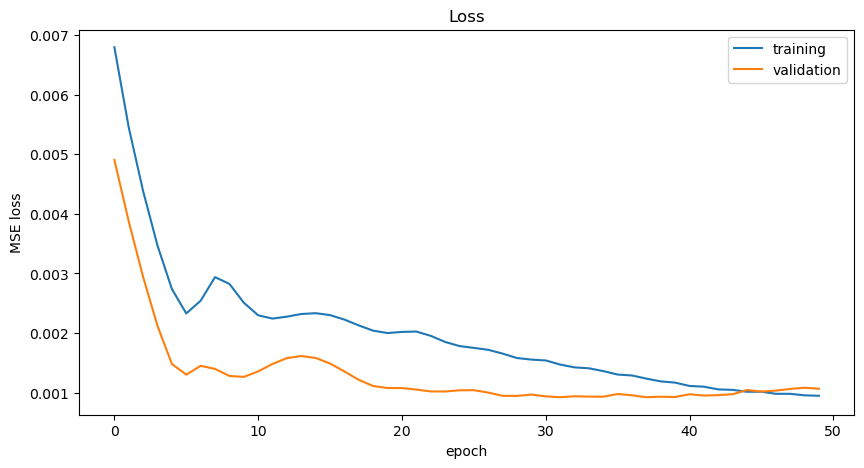

In [8]:
# plot loss over all epochs
f, ax = plt.subplots(figsize=(10,5))
ax.plot(train_loss, label='training')
ax.plot(val_loss, label='validation')
ax.set_xlabel('epoch')
ax.set_ylabel('MSE loss')
ax.set_title('Loss')
ax.legend()

# save figure
# plt.savefig(f'../../figs/{model_name}_loss.png', dpi=300)

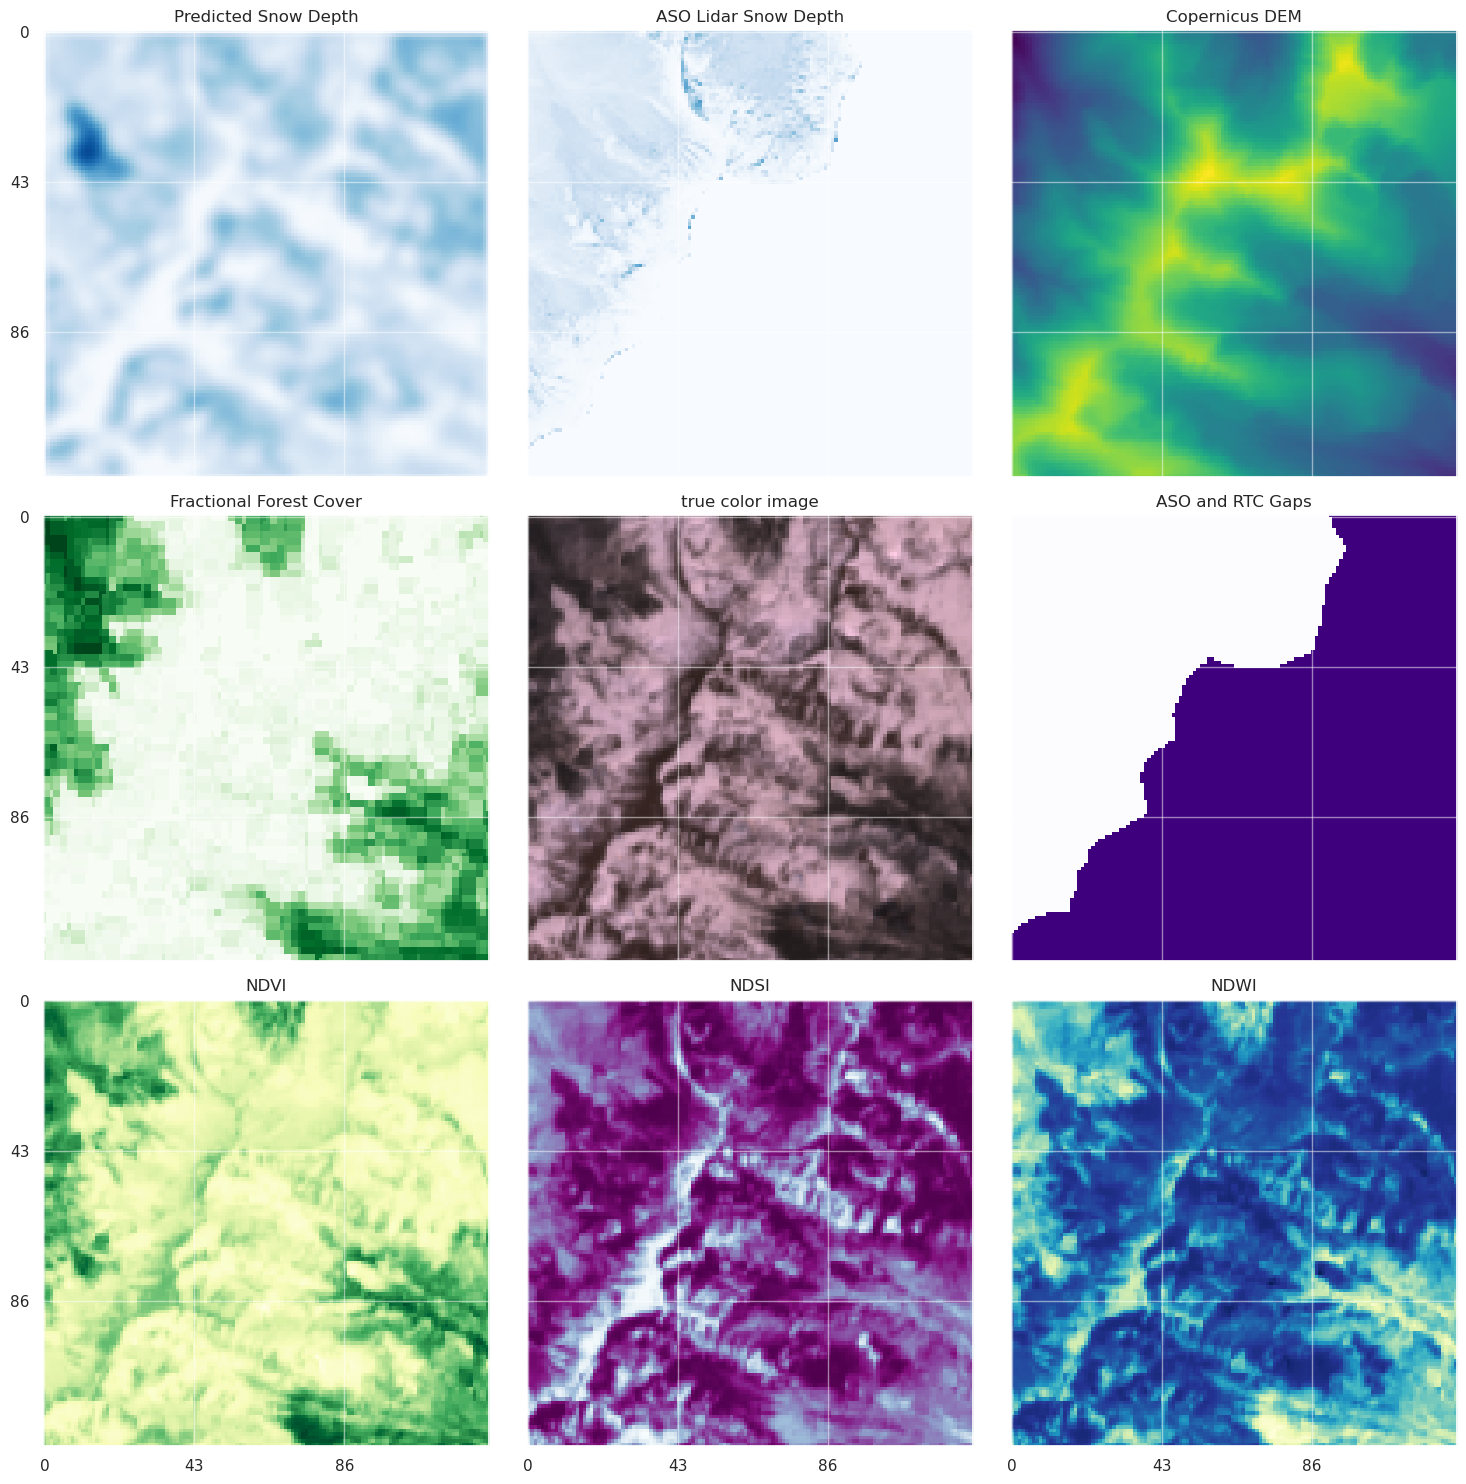

In [9]:
# visualize model predictions
sns.set_theme()
num_samples = 1

for i, data_tuple in enumerate(val_loader):
    if i < num_samples:
        # read data into dictionary
        data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}

        with torch.no_grad():
            # Concatenate input feature channels, make prediction
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
            pred_sd = model(inputs)  # Generate predictions using the model
            pred_sd = pred_sd.to('cpu')
        
        f, ax = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)
        ax[0, 0].imshow(pred_sd.squeeze(), cmap='Blues', vmin=0, vmax=0.4, interpolation=None)
        ax[0, 0].set_title('Predicted Snow Depth')
        ax[0, 1].imshow(data_dict['aso_sd'].squeeze(), cmap='Blues', vmin=0, vmax=0.4, interpolation=None)
        ax[0, 1].set_title('ASO Lidar Snow Depth')
        ax[0, 2].imshow(data_dict['elevation'].squeeze(), cmap='viridis', interpolation='none')
        ax[0, 2].set_title('Copernicus DEM')
        ax[1, 0].imshow(data_dict['fcf'].squeeze(), cmap='Greens', interpolation='none')
        ax[1, 0].set_title('Fractional Forest Cover')
        norm_max = np.max([data_dict['green'].max(), data_dict['red'].max(), data_dict['blue'].max()]) # there are better ways to do this
        ax[1, 1].imshow(torch.cat((data_dict['red'].squeeze()[:, :, None]/norm_max, data_dict['green'].squeeze()[:, :, None]/norm_max, data_dict['blue'].squeeze()[:, :, None]/norm_max), 2).squeeze(), interpolation='none')
        ax[1, 1].set_title('true color image')
        ax[1, 2].imshow(data_dict['aso_gap_map'].squeeze() + data_dict['rtc_gap_map'].squeeze() + data_dict['s2_gap_map'].squeeze(), cmap='Purples', interpolation='none')
        ax[1, 2].set_title('ASO and RTC Gaps')
        ax[2, 0].imshow(data_dict['ndvi'].squeeze(), cmap='YlGn', interpolation='none')
        ax[2, 0].set_title('NDVI')
        ax[2, 1].imshow(data_dict['ndsi'].squeeze(), cmap='BuPu', interpolation='none')
        ax[2, 1].set_title('NDSI')
        ax[2, 2].imshow(data_dict['ndwi'].squeeze(), cmap='YlGnBu', interpolation='none')
        ax[2, 2].set_title('NDWI')
        
        # modify plot style
        for a in ax.flat:
            a.set_aspect('equal')
            a.set_xticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[1], 43))
            a.set_yticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[0], 43))
            a.grid(True, linewidth=1, alpha=0.5)
        
        f.tight_layout()
    else:
        break


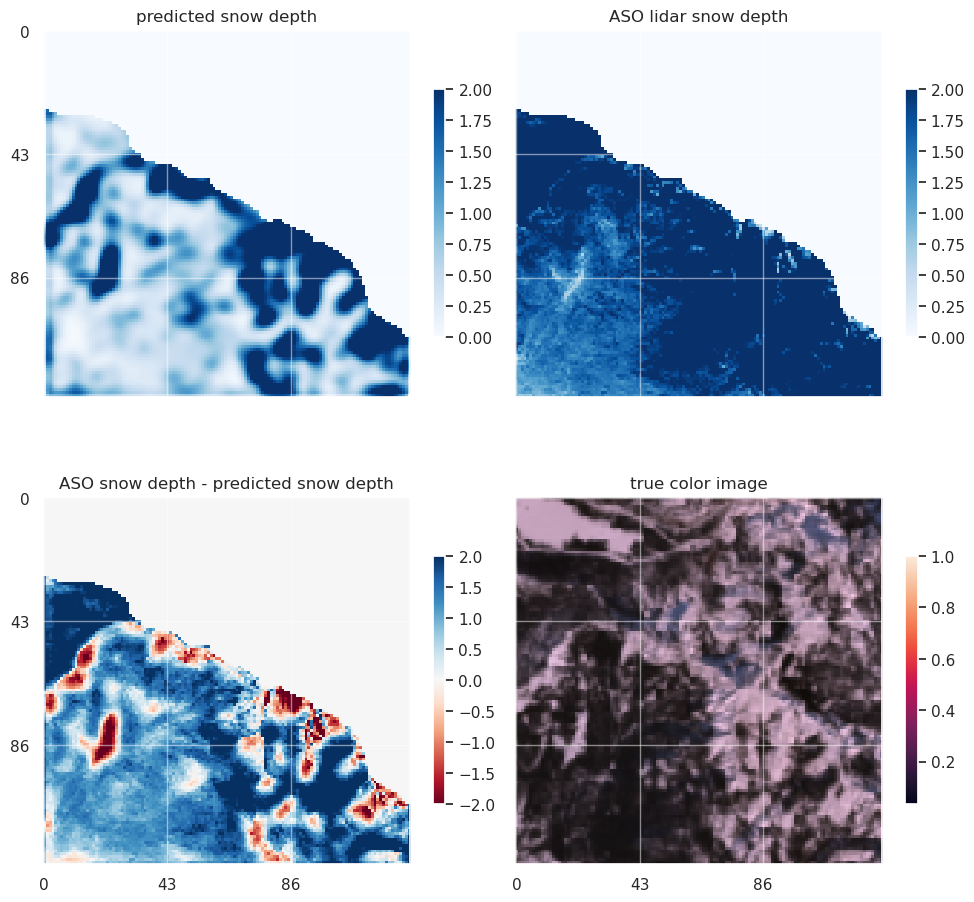

In [10]:
# visualize prediction error
sns.set_theme()
num_samples = 1
norm_dict = deep_snow.dataset.norm_dict

for i, data_tuple in enumerate(val_loader):
    if i < num_samples:
        # read data into dictionary
        data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}

        with torch.no_grad():
            # Concatenate input feature channels, make prediction
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
            pred_sd = model(inputs)  # Generate predictions using the model
            pred_sd = pred_sd.to('cpu')

            # mask nodata areas
            pred_sd = torch.where(data_dict['aso_gap_map']+data_dict['rtc_gap_map'] + data_dict['s2_gap_map'] == 0, pred_sd, torch.zeros_like(pred_sd))
            aso_sd = torch.where(data_dict['aso_gap_map']+data_dict['rtc_gap_map'] + data_dict['s2_gap_map'] == 0, data_dict['aso_sd'], torch.zeros_like(pred_sd))

            # undo normalization
            pred_sd = deep_snow.dataset.undo_norm(pred_sd, deep_snow.dataset.norm_dict['aso_sd']).squeeze()
            aso_sd = deep_snow.dataset.undo_norm(aso_sd, deep_snow.dataset.norm_dict['aso_sd']).squeeze()
            
            # mask values above 0
            pred_sd = torch.where(pred_sd >= 0, pred_sd, torch.zeros_like(pred_sd))
            
            f, ax = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)
            im0 = ax[0, 0].imshow(pred_sd, cmap='Blues', vmin=0, vmax=2, interpolation='none') 
            ax[0, 0].set_title('predicted snow depth')
            f.colorbar(im0, shrink=0.5)
            im1 = ax[0, 1].imshow(aso_sd, cmap='Blues', vmin=0, vmax=2, interpolation='none')
            ax[0, 1].set_title('ASO lidar snow depth')
            f.colorbar(im1, shrink=0.5)

            im2 = ax[1, 0].imshow(aso_sd-pred_sd, cmap='RdBu', vmin=-2, vmax=2, interpolation='none') 
            ax[1, 0].set_title('ASO snow depth - predicted snow depth')
            f.colorbar(im2, shrink=0.5)
            norm_max = np.max([data_dict['green'].max(), data_dict['red'].max(), data_dict['blue'].max()]) # there are better ways to do this
            im3 = ax[1, 1].imshow(torch.cat((data_dict['red'].squeeze()[:, :, None]/norm_max, data_dict['green'].squeeze()[:, :, None]/norm_max, data_dict['blue'].squeeze()[:, :, None]/norm_max), 2).squeeze(), interpolation='none')
            ax[1, 1].set_title('true color image')
            f.colorbar(im3, shrink=0.5)

            # modify plot style
            for a in ax.flat:
                a.set_aspect('equal')
                a.set_xticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[1], 43))
                a.set_yticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[0], 43))
                a.grid(True, linewidth=1, alpha=0.5)

            plt.tight_layout()
    else: 
        break